## 环境准备

## 本实验请在GPU上运行，如果在CPU上运行，很可能跑不起来

安装paddle深度学习框架，官网上有安装方式：https://www.paddlepaddle.org.cn/

下面两个命令二选一，请大家选择，但是安装GPU版本的paddle框架时，需要适配相应的CUDA号

In [1]:
#本次实验需要paddle版本2.3
#通过这个命令可以查看我们的paddle版本号
import paddle
print(paddle.__version__)

2.3.2


In [2]:
#安装paddle深度学习框架（这个命令是安装GPU版本，对应的是CUDA10.1）
!python -m pip install paddlepaddle-gpu==2.3.2.post101 -f https://www.paddlepaddle.org.cn/whl/linux/mkl/avx/stable.html


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/, https://mirrors.aliyun.com/pypi/simple/
Looking in links: https://www.paddlepaddle.org.cn/whl/linux/mkl/avx/stable.html
     |████████████████████████████████| 393.4 MB 30 kB/s s eta 0:00:01    |██▊                             | 33.3 MB 10.4 MB/s eta 0:00:35     |██▉                             | 35.0 MB 10.4 MB/s eta 0:00:35     |███                             | 36.6 MB 10.4 MB/s eta 0:00:35     |███▋                            | 44.0 MB 26.8 MB/s eta 0:00:14 |████▉                           | 59.4 MB 15.0 MB/s eta 0:00:23     |█████                           | 60.6 MB 15.0 MB/s eta 0:00:23         | 67.5 MB 15.0 MB/s eta 0:00:22     |██████▏                         | 76.2 MB 15.0 MB/s eta 0:00:22     |██████▎                         | 77.5 MB 15.0 MB/s eta 0:00:22     |██████▌                         | 79.8 MB 19.4 MB/s eta 0:00:17     |██████▊                         | 82.3 MB 19.4 MB/s eta 0:00:17     |███████▏        

In [8]:
#安装paddlex
!pip install paddlex

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/, https://mirrors.aliyun.com/pypi/simple/
Requirement already up-to-date: paddlex in ./.local/lib/python3.7/site-packages (2.1.0)


# 实验名称：电梯内电瓶车检测

## 实验介绍：

用深度学习+计算机视觉+目标检测算法 完成电梯内电瓶车检测任务

## 实验目标

> - 掌握paddleX进行目标检测任务的工作流程
> - 掌握本实验的核心代码

## 实验内容

### 1.准备阶段

### 1.1 数据准备  

对于本次实验的数据集，标注格式为VOC格式，标注之后生成了两个文件夹：Annotations和JPEGImages。其中Annotations用来存储数据集的xml文件；JPEGImages用来存储数据集的图片。当然文件夹名字可以不一样，那么代码中要做相应的修改。
 
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/ad198d705b3d42fb8e7f79468b9e0b90744712806ca54910a9171256bf853a9a" width=300></center>
<center>数据集结构</center>

PaddleX在训练前需要导入数据集，这就需要解析图片与xml标注文件的路径，因为PaddleX的高阶API对数据集的路径要求比较严格，所以我们首先要生成几个txt文件，来向paddleX明确图片与xml文件的路径，这样，数据集才能被paddleX解析并加载。


In [4]:
#解压数据集
!unzip -o data/user/电瓶车电梯预警实战数据集/dataset.zip

Archive:  data/user/电瓶车电梯预警实战数据集/dataset.zip
  inflating: dataset/Annotations/1.xml  
  inflating: dataset/Annotations/10.xml  
  inflating: dataset/Annotations/11.xml  
  inflating: dataset/Annotations/12.xml  
  inflating: dataset/Annotations/13.xml  
  inflating: dataset/Annotations/14.xml  
  inflating: dataset/Annotations/15.xml  
  inflating: dataset/Annotations/16.xml  
  inflating: dataset/Annotations/17.xml  
  inflating: dataset/Annotations/18.xml  
  inflating: dataset/Annotations/19.xml  
  inflating: dataset/Annotations/2.xml  
  inflating: dataset/Annotations/20.xml  
  inflating: dataset/Annotations/21.xml  
  inflating: dataset/Annotations/22.xml  
  inflating: dataset/Annotations/23.xml  
  inflating: dataset/Annotations/24.xml  
  inflating: dataset/Annotations/25.xml  
  inflating: dataset/Annotations/26.xml  
  inflating: dataset/Annotations/27.xml  
  inflating: dataset/Annotations/28.xml  
  inflating: dataset/Annotations/29.xml  
  inflating: dataset/Annotations/

In [1]:
# -*- coding: utf-8 -*-
'''
说明：
       本文件的作用是解析数据集中图片与xml文件的路径；
       运行这个文件会生成四个个txt文件：
            labels.txt用来存储数据集中瑕疵的各个类别名称；
            train_list.txt用来存储训练集的图片，及对应的xml文件路径；
            val_list.txt用来存储验证集的图片，及对应的xml文件路径；
            test_list.txt用来存储测试集的图片，及对应的xml文件路径；

'''


import os       # OS模块含有文件操作的功能，对数据集读取时会用到该模块。
import random   # 导入 random 模块，用于随时生成数据
random.seed(0)  # 当我们设置相同的seed，每次生成的随机数相同

num_class = ['ebike']  #数据集中所有类名

xmlfilepath=r'./dataset/Annotations'   #xmlfilepath存储Annotations文件夹的路径
saveBasePath=r"./dataset/"             #saveBasePath用来存储生成的txt文件路径
trainval_percent=0.98          #train+val数据集占总数据集98%，test占总数据集2%（主要用于进一步拆分数据集，属于中间变量）
train_percent=0.8              #train占数据集80%

temp_xml = os.listdir(xmlfilepath)  #temp_xml存储Annotations文件夹里的文件
total_xml = []                      #total_xml存储后缀为xml的文件
for xml in temp_xml:                #对于Annotations文件夹里的所有文件，如果文件是xml文件，将文件加入到total_xml中
    if xml.endswith(".xml"):
        total_xml.append(xml)

num=len(total_xml)                  #num为xml文件的个数
list=range(num)                     #list为所有xml文件的序号（0，1，2，3，...，num)
tv=int(num*trainval_percent)        #tv为train+val数据集的个数
tr=int(num*train_percent)             #tr为tarin数据集的个数
trainval= random.sample(list,tv)    #trainval存储train数据集和val数据集的文件序号
train=random.sample(trainval,tr)    #train存储train数据集的文件序号
 
print("train and val size",tv)                                      #检查train+val数据集个数
print("train size",tr)                                              #检查train数据集个数
ftest = open(os.path.join(saveBasePath,'test_list.txt'), 'w')       #创建一个file对象来将test的数据名写入test_list.txt文件
ftrain = open(os.path.join(saveBasePath,'train_list.txt'), 'w')     #创建一个file对象来将train数据名写入train_list.txt文件
fval = open(os.path.join(saveBasePath,'val_list.txt'), 'w')         #创建一个file对象来将val数据名写入val_list.txt
flabel = open(os.path.join(saveBasePath,'labels.txt'), 'w') #创建一个file对象来将label数据名写入labels.txt
for i in num_class:                                         #遍历所有的label名称
    flabel.write(i + "\n")                                  #将名称写入文件
flabel.close()                                              #关闭labels.txt文件

for i  in list:                         #遍历所有xml文件
    name=total_xml[i][:-4]+'\n'         #name存储这一行文件内容
    if i in trainval:                   #该文件在train+val数据集中，进一步检测是train数据集还是val数据集
        if i in train:                  #该文件在train数据集中，将其写入train_list.txt文件
            ftrain.write("Images/" + name.strip().split(".")[0] + ".png" + " " + "Annotations/" + name.strip().split(".")[0] + ".xml" + "\n")
        else:                           #该文件在val数据集中，将其写入val_list.txt文件 
            fval.write("Images/" + name.strip().split(".")[0] + ".png" + " " + "Annotations/" + name.strip().split(".")[0] + ".xml" + "\n")
    else:                               #该文件在test数据集中，将其写入test_list.txt文件
        ftest.write("Images/" + name.strip().split(".")[0] + ".png" + " " + "Annotations/" + name.strip().split(".")[0] + ".xml" + "\n")
             
ftrain.close()          #关闭train_list.txt文件
fval.close()            #关闭val_list.txt文件
ftest .close()          #关闭test_list.txt文件

train and val size 29
train size 24


运行上面的代码后，就会生成四个txt文件：  

> - labels.txt用来存储数据集中瑕疵的各个类别名称；
> - train_list.txt用来存储训练集的图片，及对应的xml文件路径；
> - val_list.txt用来存储验证集的图片，及对应的xml文件路径；
> - test_list.txt用来存储测试集的图片，及对应的xml文件路径；  


通过这四个文件，数据集已经被分成了训练集（train）、验证集（val）、测试集（test）。


### 1.2 数据预处理  

为了训练出一个效果更好的模型，在数据集加载进网络之前，一般要对数据进行预处理，比如改变一下输入图片的尺寸，使得图片更适合网络的运算。或者，我们也可以用一些数据增强技术，来扩充我们的数据集（说明：对于数据增强的原理，我们会在后面课程中详细讲解）。paddleX中定义了一个图像处理流程transforms，在transforms中，我们可以定义数据集的预处理方式，也可以定义数据增强的方式，使用起来非常方便。如下代码可实现数据预处理：


In [1]:
# -*- coding: utf-8 -*-
'''
说明：
       本文件展示了paddleX高阶API的使用过程；
       本文件通过调用paddleX高阶API可以实现数据导入、模型训练、模型预测等工作；
   
'''

# 导入matplotlib绘图库
import matplotlib
#在导入matplotlib库后，且在matplotlib.pyplot库被导入前加“matplotlib.use(‘agg’)”语句，可以使得在PyCharm中不显示绘图。
matplotlib.use('Agg') 

# OS模块含有文件操作的功能，对数据集读取时会用到该模块。
import os
# 设置使用0号GPU卡（如无GPU，执行此代码后仍然会使用CPU训练模型）
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
#导入paddleX的高阶API
import paddlex as pdx

#定义图像处理流程transforms
#定义训练数据的预处理方式，为了模型效果更好，可以对训练数据进行数据增强
#如下代码中，训练过程使用了MixupImage、RandomDistort、RandomExpand、RandomCrop、Resize和RandomHorizontalFlip共6种数据增强方式
#from paddlex.det import transforms  #这条语句是paddleX1.3的语句
from paddlex import transforms   #这条语句是paddleX2. 的语句

#对目标检测任务的数据进行操作。可以利用Compose类将图像预处理/增强操作进行组合
train_transforms = transforms.Compose([
    #以一定的概率对图像进行随机像素内容变换，以达到数据增强的目的
    transforms.RandomDistort(),
    #随机扩张图像，以达到数据增强的目的
    transforms.RandomExpand(),
    #随机裁剪图像，以达到数据增强的目的
    transforms.RandomCrop(),
    #调整图像大小（resize）
    #target_size 表示 短边目标长度。默认为608。
    transforms.Resize(target_size=608, interp='RANDOM'),
    #以一定的概率对图像进行随机水平翻转，以达到数据增强的目的
    transforms.RandomHorizontalFlip(),
    #对图像进行标准化
    transforms.Normalize(), 
])


/opt/conda/lib/python3.7/site-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
2022-11-10 12:12:48,490-WARNING: type object 'QuantizationTransformPass' has no attribute '_supported_quantizable_op_type'
2022-11-10 12:12:48,493-WARNING: If you want to use training-aware and post-training quantization, please use Paddle >= 1.8.4 or develop version
/opt/conda/lib/python3.7/site-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/opt/conda/lib/python3.7/site-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.

上面的代码中，对于训练数据集，我们使用了MixupImage、RandomDistort、RandomExpand、RandomCrop和RandomHorizontalFlip共5种数据增强方式。我们利用Compose类将图像预处理/增强操作进行了组合。  

同样的道理，对于验证集，我们也可以transforms.Compose()来进行数据的预处理，但是验证数据不需要数据增强，所以我们只需要改变一下图片的尺寸，把图片变成608×608大小，这个尺寸特别适合yolov3网络模型的运算。并且，我们也要对验证集的图片进行标准化操作。因此，去除数据增强相关代码后的代码如下。


In [2]:
#定义验证集的预处理方式，验证数据不需要数据增强
eval_transforms = transforms.Compose([
    #调整图像大小（resize）
    #target_size 表示 短边目标长度。默认为608。
    transforms.Resize(target_size=608, interp='CUBIC'),
    #对图像进行标准化
    transforms.Normalize(),
])



### 1.3 加载数据  

接下来，我们需要定义数据集Dataset，用来加载数据。在paddleX的高阶API中，目标检测可使用VOC和COCO两种数据加载方式。由于我们的数据集为VOC格式标注的，因此采用pdx.datasets.VOCDetection来加载训练数据集。
同样的道理，我们也可以用pdx.datasets.VOCDetection来加载验证数据，代码如下：



In [3]:
#定义数据集Dataset，用来加载数据
#目标检测可使用VOCDetection格式和COCODetection两种数据集，
#此处由于我们的数据集为VOC格式，因此采用pdx.datasets.VOCDetection来加载数据集，
train_dataset = pdx.datasets.VOCDetection(    
    data_dir='dataset',                 #数据集路径
    file_list='dataset/train_list.txt', #指向train_list.txt的路径，也即是训练集的路径
    label_list='dataset/labels.txt',    #指向labels.txt的路径
    transforms=train_transforms,
    shuffle=True)

    
eval_dataset = pdx.datasets.VOCDetection(
    data_dir='dataset',
    file_list='dataset/val_list.txt', #指向val_list.txt的路径，也即是验证集的路径
    label_list='dataset/labels.txt',  #指向labels.txt的路径
    transforms=eval_transforms)


2022-11-10 12:12:56 [INFO]	Starting to read file list from dataset...
2022-11-10 12:12:57 [INFO]	24 samples in file dataset/train_list.txt, including 24 positive samples and 0 negative samples.
creating index...
index created!
2022-11-10 12:12:57 [INFO]	Starting to read file list from dataset...
2022-11-10 12:12:57 [INFO]	5 samples in file dataset/val_list.txt, including 5 positive samples and 0 negative samples.
creating index...
index created!


**注意：**

上面代码中buffer_size表示数据集中样本在预处理过程中队列的缓存长度，这个值如果设置的过大，则会出现memory manager的问题，程序会报错。所以这个值不能设置过大。


### 2. 训练与评估  

准备阶段的工作完成之后，我们就可以进行模型的训练了， 代码如下。


In [4]:
#模型训练    
#模型训练过程每间隔save_interval_epochs轮会保存一次模型在save_dir目录下，
#同时在保存的过程中也会在验证数据集上计算相关指标
num_classes = len(train_dataset.labels) #num_classes表示瑕疵的类别数

#如果模型不需要部署到嵌入式上，则可以调用paddleX高阶API中的yolov3算法，其backbone为DarkNet53
model = pdx.det.YOLOv3(num_classes=num_classes, backbone='DarkNet53')   

#但是如果部署到嵌入式上，则需要把yolov3模型换成PP-PicoDet模型
#model = pdx.det.PicoDet(num_classes=num_classes, backbone='ESNet_l')


model.train(    
    num_epochs=100, #训练的epoch数
    train_dataset=train_dataset,    #加载增强后的训练数据
    train_batch_size=2,             #每一批次大小
    eval_dataset=eval_dataset,      #导入验证数据
    #pretrain_weights='output_model/epoch_100/model.pdparams',  #在第100个epoch基础上继续训练
    #pretrain_weights=None,  #从0开始训练
    pretrain_weights='COCO',  #使用coco上训练好的模型
    learning_rate=0.000125,         #学习率
    lr_decay_epochs=[50, 100],     #采用可变学习率，在这里规定学习率的范围，把epoch分为0-50、50-100、100-以上  三个范围，每个范围内采用不同的学习率
    save_interval_epochs=20,        #每隔多少epoch保存一次模型
    save_dir='output_model',        #模型的保存位置
    use_vdl=True)




W1110 12:12:57.194294  6783 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.0, Runtime API Version: 10.1
W1110 12:12:57.202292  6783 gpu_resources.cc:91] device: 0, cuDNN Version: 7.6.


2022-11-10 12:12:59 [INFO]	Downloading yolov3_darknet53_270e_coco.pdparams from https://paddledet.bj.bcebos.com/models/yolov3_darknet53_270e_coco.pdparams


100%|██████████| 242236/242236 [00:11<00:00, 20516.17KB/s]


2022-11-10 12:13:11 [INFO]	Loading pretrained model from output_model/pretrain/yolov3_darknet53_270e_coco.pdparams
2022-11-10 12:13:14 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.0.weight doesn't match.(Pretrained: [255, 1024, 1, 1], Actual: [18, 1024, 1, 1])
2022-11-10 12:13:14 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.0.bias doesn't match.(Pretrained: [255], Actual: [18])
2022-11-10 12:13:14 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.1.weight doesn't match.(Pretrained: [255, 512, 1, 1], Actual: [18, 512, 1, 1])
2022-11-10 12:13:14 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.1.bias doesn't match.(Pretrained: [255], Actual: [18])
2022-11-10 12:13:14 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.2.weight doesn't match.(Pretrained: [255, 256, 1, 1], Actual: [18, 256, 1, 1])
2022-11-10 12:13:14 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.2.bias doesn't match

> - 以上代码中，通过调用pdx.det.YOLOv3来构建一个基于YOLOv3算法的检测器。也就是说，在paddleX中，我们不需要再自己搭建yolov3算法的网络结构了，paddleX的API会帮我们搭建好。

> - pdx.det.YOLOv3有一些参数需要注意。num_classes不需要包含背景类，比如咱们本次实验的待检测物体共3类，则num_classes设为3即可，这里与FasterRCNN/MaskRCNN有差别。


> - lr_decay_epochs=[100, 200]表示我们采用可变学习率。[100, 200]规定了学习率的范围，表示把epoch分为“0-100、100-200、200-以上”三个范围，每个范围内采用不同的学习率。比如本次代码中，我们在0-100个epoch内，使用的learning_rate=0.000125，在100-200个epoch内，是学习率衰减0.1倍，变成0.0000125，当200个epoch以上时，学习率再次衰减0.1倍。


> - 以上代码中，模型训练过程每间隔save_interval_epochs轮会保存一次模型在save_dir目录下，同时在保存的过程中也会在验证数据集上计算相关指标。训练过程会持续十几个小时，当模型评估的loss值不再减小，或者变化不大时，就可以停止训练了。训练过程的轮次epoch、损失值loss，学习率lr等信息变化，如图所示。
 
 <center><img src="https://ai-studio-static-online.cdn.bcebos.com/877fc6ca58ea49619891a6f1056f469b375e43f2a4aa48b996ce5835808c4efe" width=600></center>
<center></center>
 
可以看到，随着训练的加深，loss值逐渐在减小。
模型训练结束后，通过语句eval_dataset=eval_dataset把验证集加载进模型，可以进行模型的评估。并且把评估结果输出在屏幕上，如下图所示。

 <center><img src="https://ai-studio-static-online.cdn.bcebos.com/585ff8593a004631b7e50e32beebdfc9ed242bcade714775999b622e83ee745e" width=600></center>
<center></center>
从图中最后一行代码，可以读出，在验证集上，当前最好的模型是epoch_10，预测框的mAP值为4.12。评估后，会把效果最好的模型保存下来，名字为best_model。


### 3. 预测展示
经过漫长的模型训练和评估之后，我们保存好一个效果不错的模型，就可以用这个模型进行预测，并把预测结果可视化的展示出来。预测部份代码如下。


In [8]:
#预测阶段    
import paddlex as pdx
#加载训练好的模型
model = pdx.load_model('output_model/best_model')
#选择待预测的图片
image_name = 'dataset/Images/1.png'
#启动预测
result = model.predict(image_name)
#使用pdx.det.visualize将结果可视化，可视化结果将保存到save_dir目录下，
#其中threshold代表Box的置信度阈值，将Box置信度低于该阈值的框过滤掉，不进行可视化。
pdx.det.visualize(image_name, result, threshold=0.2, save_dir='./')



2022-11-10 12:41:04 [INFO]	Model[YOLOv3] loaded.
2022-11-10 12:41:05 [INFO]	The visualized result is saved at ./visualize_1.png


以上代码中，我们使用pdx.det.visualize将预测的结果可视化展示出来，可视化结果是一张jpg图片，程序会将该图片保存到save_dir目录下。其中参数threshold代表Box的置信度阈值， 如果模型预测出的矩形框的置信度很低，低于这个threshold值，则这个预测框不会展示出来。

## 第二阶段：模型导出（模型格式转换）

以下命令，在本notebook界面运行可能会出现问题，所以建议大家在terminel中运行。

运行命令如下：

paddlex --export_inference --model_dir=./output_model/best_model/ --save_dir=./inference_model


In [13]:
# #这个命令在本notebook界面运行可能会出现问题，所以建议大家在terminel中运行
# #模型导出（模型格式转换）
# #要保证paddle深度学习框架版本>=2.3  
# !paddlex --export_inference --model_dir=./output_model/best_model/ --save_dir=./inference_model

/bin/bash: paddlex: command not found


## 第三阶段 服务器端部署测试

在本页上利用paddle inference  测试部署后的预测代码是否能用

I1114 09:53:33.117102   182 analysis_config.cc:53] Create CPU IR passes
--- Running analysis [ir_graph_build_pass]
--- Running analysis [ir_graph_clean_pass]
--- Running analysis [ir_analysis_pass]
--- Running IR pass [simplify_with_basic_ops_pass]
--- Running IR pass [layer_norm_fuse_pass]
---    Fused 0 subgraphs into layer_norm op.
--- Running IR pass [attention_lstm_fuse_pass]
--- Running IR pass [seqconv_eltadd_relu_fuse_pass]
--- Running IR pass [seqpool_cvm_concat_fuse_pass]
--- Running IR pass [mul_lstm_fuse_pass]
--- Running IR pass [fc_gru_fuse_pass]
---    fused 0 pairs of fc gru patterns
--- Running IR pass [mul_gru_fuse_pass]
--- Running IR pass [seq_concat_fc_fuse_pass]
--- Running IR pass [gpu_cpu_squeeze2_matmul_fuse_pass]
--- Running IR pass [gpu_cpu_reshape2_matmul_fuse_pass]
--- Running IR pass [gpu_cpu_flatten2_matmul_fuse_pass]
--- Running IR pass [matmul_v2_scale_fuse_pass]
--- Running IR pass [gpu_cpu_map_matmul_v2_to_mul_pass]
--- Running IR pass [gpu_cpu_map_ma

frame  保存好了


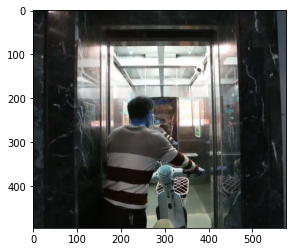

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
from paddle.inference import Config
from paddle.inference import PrecisionType
from paddle.inference import create_predictor
import yaml
import time

def resize(img, target_size):
    """resize to target size"""
    if not isinstance(img, np.ndarray):
        raise TypeError('image type is not numpy.')
    im_shape = img.shape
    im_size_min = np.min(im_shape[0:2])
    im_size_max = np.max(im_shape[0:2])
    im_scale_x = float(target_size) / float(im_shape[1])
    im_scale_y = float(target_size) / float(im_shape[0])
    img = cv2.resize(img, None, None, fx=im_scale_x, fy=im_scale_y)
    return img

def normalize(img, mean, std):
    img = img / 255.0
    mean = np.array(mean)[np.newaxis, np.newaxis, :]
    std = np.array(std)[np.newaxis, np.newaxis, :]
    img -= mean
    img /= std
    return img

def preprocess(img, img_size):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = resize(img, img_size)
    img = img[:, :, ::-1].astype('float32')  # bgr -> rgb
    img = normalize(img, mean, std)
    img = img.transpose((2, 0, 1))  # hwc -> chw
    return img[np.newaxis, :]

def predict_config(model_file, params_file):
    '''
    函数功能：初始化预测模型predictor
    函数输入：模型结构文件，模型参数文件
    函数输出：预测器predictor
    '''
    # 根据预测部署的实际情况，设置Config
    config = Config()
    # 读取模型文件
    config.set_prog_file(model_file)
    config.set_params_file(params_file)
    # # Config默认是使用CPU预测，若要使用GPU预测，需要手动开启，设置运行的GPU卡号和分配的初始显存。
    # config.enable_use_gpu(500, 0)
    # # 可以设置开启IR优化、开启内存优化。
    # config.switch_ir_optim()
    # config.enable_memory_optim()
    # config.enable_tensorrt_engine(workspace_size=1 << 30, precision_mode=PrecisionType.Float32,max_batch_size=1, min_subgraph_size=5, use_static=False, use_calib_mode=False)
    predictor = create_predictor(config)
    return predictor

def predict(predictor, img):

    '''
    函数功能：初始化预测模型predictor
    函数输入：模型结构文件，模型参数文件
    函数输出：预测器predictor
    '''
    input_names = predictor.get_input_names()
    for i, name in enumerate(input_names):
        input_tensor = predictor.get_input_handle(name)
        input_tensor.reshape(img[i].shape)
        input_tensor.copy_from_cpu(img[i].copy())
    # 执行Predictor
    predictor.run()
    # 获取输出
    results = []
    # 获取输出
    output_names = predictor.get_output_names()
    for i, name in enumerate(output_names):
        output_tensor = predictor.get_output_handle(name)
        output_data = output_tensor.copy_to_cpu()
        results.append(output_data)
    return results

def draw_bbox_image(frame, result, label_list, threshold=0.5):

    for res in result:
        cat_id, score, bbox = res[0], res[1], res[2:]
        if score < threshold:
            continue
        for i in bbox:
            int(i)
        xmin, ymin, xmax, ymax = bbox
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (255,0,255), 2)
        print('category id is {}, bbox is {}'.format(cat_id, bbox))
        try:
            label_id = label_list[int(cat_id)]
            # #cv2.putText(图像, 文字, (x, y), 字体, 大小, (b, g, r), 宽度)
            cv2.putText(frame, label_id, (int(xmin), int(ymin-2)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
            cv2.putText(frame, str(round(score,2)), (int(xmin-35), int(ymin-2)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
        except KeyError:
            pass

    cv2.imwrite("saved.png", frame)
    plt.imshow(frame)
    print('frame  保存好了')

if __name__ == "__main__":

    label_list = ['ebike']

    # 配置模型参数
    model_file = "inference_model/inference_model/model.pdmodel"
    params_file = "inference_model/inference_model/model.pdiparams"
    # 初始化预测模型
    predictor = predict_config(model_file, params_file)

    # 图像尺寸相关参数初始化
    
    img = cv2.imread('dataset/Images/1.png')
    im_size = 608  #这个尺寸必须和训练时的尺寸一摸一样，否则就会报错
    scale_factor = np.array([im_size * 1. / img.shape[0], im_size * 1. / img.shape[1]]).reshape((1, 2)).astype(np.float32)
    im_shape = np.array([im_size, im_size]).reshape((1, 2)).astype(np.float32)
    

    # 预处理
    data = preprocess(img, im_size)
   
    # 预测
    result = predict(predictor, [im_shape, data, scale_factor])

    draw_bbox_image(img, result[0], label_list, threshold=0.5)

    

